# Project Overview

Proyek ini bertujuan untuk mengembangkan sistem rekomendasi destinasi wisata di Indonesia menggunakan pendekatan Content-based Filtering dan Collaborative Filtering. Dengan meningkatnya jumlah wisatawan, sistem rekomendasi ini diharapkan dapat membantu pengguna menemukan destinasi yang sesuai dengan preferensi mereka.

# Business Understanding

## Problem Statements
1. Bagaimana memberikan rekomendasi destinasi wisata yang relevan berdasarkan konten deskripsi dan kategori?
2. Bagaimana memanfaatkan data rating pengguna untuk meningkatkan akurasi rekomendasi?
3. Bagaimana mengukur relevansi rekomendasi untuk memastikan sistem memberikan hasil yang tepat?

## Goals
1. Membangun sistem rekomendasi berbasis konten yang efektif menggunakan deskripsi dan kategori destinasi wisata.
2. Membangun sistem rekomendasi destinasi wisata berdasarkan pola rating pengguna.
3. Mengukur performa sistem rekomendasi menggunakan metrik evaluasi yang sesuai

#### Solution Approach

1. **Preprocessing:**  
a. Penggabungan Deskripsi dan Kategori Menjadi Tags  
b. Pembersihan Teks  
c. Vektorisasi Teks dengan TF-IDF Vectorizer  

2. **Modelling**  
Kami mengimplementasikan dua pendekatan berikut untuk membangun sistem rekomendasi:  
a. Content-based Filtering  
b. Collaborative Filtering

3. **Evaluasi**  
Melakukan evaluasi untuk mengetahui performa sistem rekomendasi.

## Menyiapkan Lingkungan Kerja di Google Colab
### Menghubungkan Google Colab dengan Kaggle API
**Upload kaggle.json ke Google Colab:**

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"alfikiafan","key":"e723af59b9cdebeb6156c3c78312d0ca"}'}

**Mengatur permissions dan memindahkan file:**

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Mengunduh dataset**

In [3]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination
!mkdir -p dataset
!unzip -o -q indonesia-tourism-destination.zip -d dataset
!rm indonesia-tourism-destination.zip

Dataset URL: https://www.kaggle.com/datasets/aprabowo/indonesia-tourism-destination
License(s): copyright-authors
  0% 0.00/158k [00:00<?, ?B/s]
100% 158k/158k [00:00<00:00, 82.2MB/s]


### Mengimpor Seluruh Library yang Diperlukan

In [4]:
!pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 3.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Memuat Dataset Menggunakan Pandas
Setelah dataset diunduh dan diekstrak, data dimuat menggunakan pandas.

In [6]:
# Membaca dataset
data_tourism_rating = pd.read_csv('dataset/tourism_rating.csv')
data_tourism_with_id = pd.read_csv('dataset/tourism_with_id.csv')

## Data Understanding

Dataset yang digunakan terdiri dari dua file utama:
1. **tourism_with_id.csv**: Berisi informasi detail tentang destinasi wisata, termasuk nama, deskripsi, kategori, lokasi, harga, rating, dan koordinat.
2. **tourism_rating.csv**: Berisi data rating yang diberikan oleh pengguna terhadap destinasi wisata tertentu.

### Eksplorasi Data
- **Jumlah Data:**
  - `tourism_with_id.csv` memiliki 437 baris dan 11 kolom.
  - `tourism_rating.csv` memiliki 10.000 baris dan 3 kolom.
- **Deskripsi Fitur:**
  - `Place_Id`: Identifikasi unik untuk setiap destinasi wisata.
  - `Place_Name`: Nama destinasi wisata.
  - `Description`: Deskripsi singkat tentang destinasi.
  - `Category`: Kategori destinasi (misalnya, Budaya, Alam).
  - `City`: Kota tempat destinasi berada.
  - `Price`: Harga tiket masuk.
  - `Rating`: Rating rata-rata dari pengguna.
  - `Time_Minutes`: Waktu yang dibutuhkan untuk mengunjungi.
  - `Coordinate`: Koordinat geografis.
  - `Lat`: Latitude lokasi.
  - `Long`: Longitude lokasi
  - `Unnamed: 11`: Kolom kosong
  - `Unnamed: 12`: Kolom kosong

- **Visualisasi Data:**
  - Distribusi Rating Destinasi Wisata
  - Jumlah Destinasi per Kategori
  - Jumlah Rating per Destinasi (Top 10)

## Exploratory Data Analysis
EDA bertujuan untuk memahami lebih dalam tentang data yang kita miliki. Berikut adalah langkah-langkah EDA yang lebih mendalam untuk dataset ini.

### Pemeriksaan Dimensi dan Struktur Data
Kita akan mulai dengan memahami struktur setiap dataset

In [7]:
print("Dataset Tourism Rating:")
display(data_tourism_rating.head())

print("\nInformasi Dataset Tourism Rating:")
display(data_tourism_rating.info())

Dataset Tourism Rating:


,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4



Informasi Dataset Tourism Rating:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


None

In [9]:
print("Dataset Tourism with ID:")
display(data_tourism_with_id.head())

print("\nInformasi Dataset Tourism with ID:")
display(data_tourism_with_id.info())

Dataset Tourism with ID:


,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5



Informasi Dataset Tourism with ID:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


None

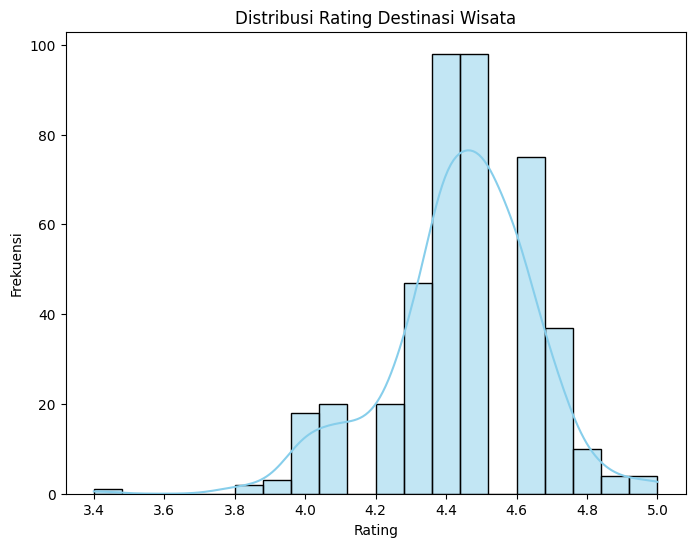

In [17]:
# Distribusi Rating Destinasi Wisata
plt.figure(figsize=(8,6))
sns.histplot(data_tourism_with_id['Rating'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Rating Destinasi Wisata')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

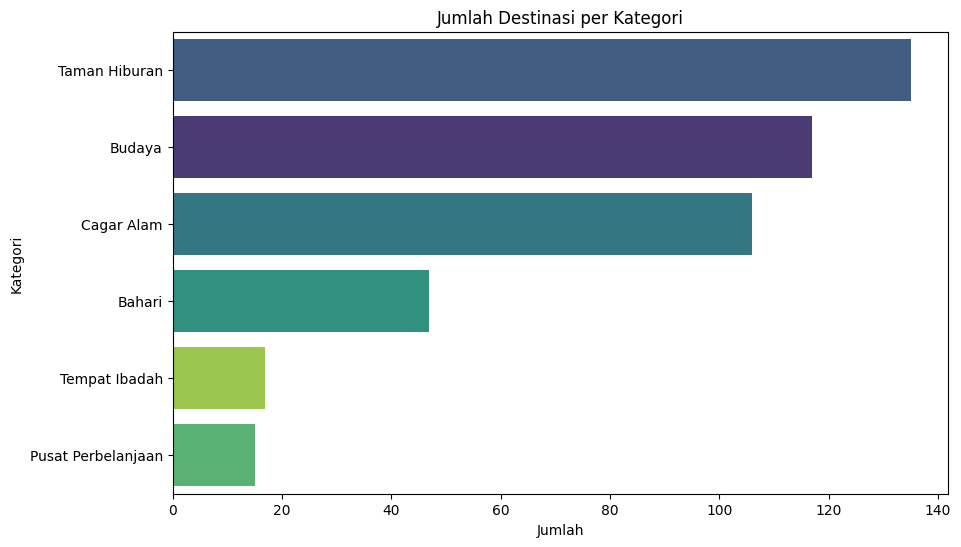

In [18]:
# Jumlah Destinasi per Kategori
plt.figure(figsize=(10,6))
sns.countplot(data=data_tourism_with_id, y='Category', order=data_tourism_with_id['Category'].value_counts().index, palette='viridis', hue='Category', legend=False)
plt.title('Jumlah Destinasi per Kategori')
plt.xlabel('Jumlah')
plt.ylabel('Kategori')
plt.show()

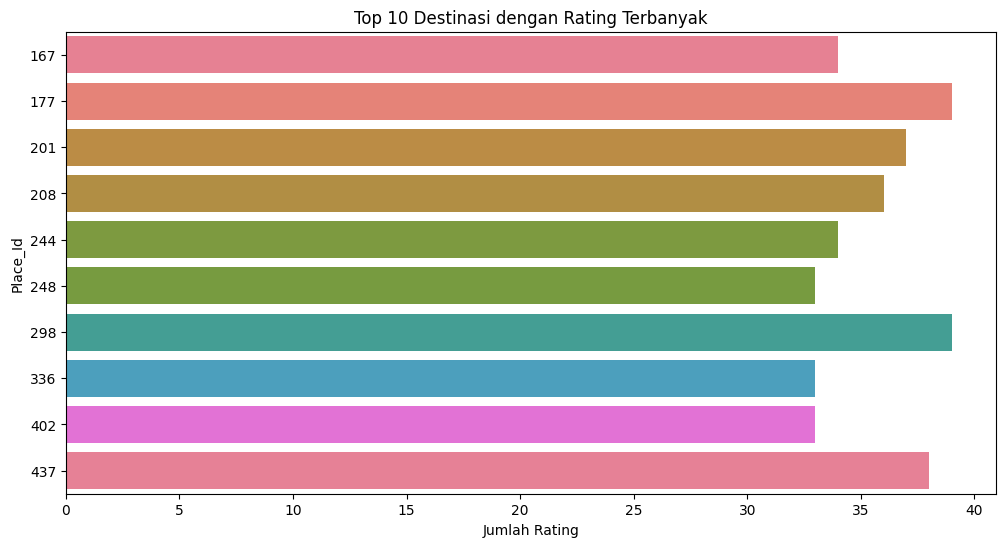

In [19]:
# Jumlah Rating per Destinasi (Top 10)
plt.figure(figsize=(12,6))
rating_counts = data_tourism_rating['Place_Id'].value_counts().head(10)
sns.barplot(x=rating_counts.values, y=rating_counts.index, orient='h', palette='husl', hue=rating_counts.index, legend=False)
plt.title('Top 10 Destinasi dengan Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Place_Id')
plt.show()

## Data Preparation

### Langkah-langkah yang Dilakukan:
1. **Mengatasi Missing Values:**
   - Memeriksa nilai yang hilang pada kedua dataset.
   - Menghapus kolom yang tidak relevan atau memiliki banyak nilai yang hilang.

2. **Membagi data menjadi train dan test**

2. **Menggabungkan Dataset:**
   - Menggabungkan `tourism_rating.csv` dengan `tourism_with_id.csv` berdasarkan `Place_Id` untuk memperoleh informasi lengkap tentang setiap destinasi beserta rating rata-rata.

In [20]:
# Cek nilai yang hilang
print("Nilai yang hilang di tourism_with_id:")
print(data_tourism_with_id.isna().sum())

print("\nNilai yang hilang di tourism_rating:")
print(data_tourism_rating.isna().sum())

Nilai yang hilang di tourism_with_id:
Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64

Nilai yang hilang di tourism_rating:
User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64


In [21]:
# Menghapus kolom yang tidak diperlukan dengan mengabaikan error jika kolom tidak ditemukan
columns_to_drop = ['City', 'Price', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Unnamed: 11', 'Unnamed: 12']
data_tourism_with_id_clean = data_tourism_with_id.drop(columns=columns_to_drop, axis=1, errors='ignore')
print("\nKolom setelah penghapusan:")

print(data_tourism_with_id_clean.columns)


Kolom setelah penghapusan:
Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'Rating'], dtype='object')


In [51]:
# Menggabungkan Dataset Rating dengan Data Destinasi
recommendation_data = pd.merge(
    data_tourism_rating.groupby('Place_Id')['Place_Ratings'].mean().reset_index(),
    data_tourism_with_id_clean,
    on='Place_Id'
)

# Mengisi Nilai NaN pada Kolom 'Description' dan 'Category' dengan String Kosong
recommendation_data['Description'] = recommendation_data['Description'].fillna('')
recommendation_data['Category'] = recommendation_data['Category'].fillna('')

# Memeriksa keunikan 'Place_Name'
if recommendation_data['Place_Name'].duplicated().any():
    print("Peringatan: Terdapat 'Place_Name' yang duplikat.")

print("\nData Rekomendasi setelah penggabungan (Train Data):")
display(recommendation_data.head())


Data Rekomendasi setelah penggabungan (Train Data):


,Place_Id,Place_Ratings,Place_Name,Description,Category,Rating
0,1,3.722222,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,4.6
1,2,2.840000,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,4.6
2,3,2.526316,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,4.6
3,4,2.857143,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,4.5
4,5,3.520000,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,4.5


### Persiapan data untuk content-based filtering:
1. **Preprocessing Teks:**
   - Menggabungkan deskripsi dan kategori menjadi satu teks.
   - Melakukan lowercase, stemming, dan penghapusan stopword menggunakan library Sastrawi.

2. **Vektorisasi Teks:**
   - Menggunakan `TfidfVectorizer` untuk mengubah teks menjadi vektor numerik.

3. **Menghitung Similarity:**
   - Menggunakan cosine similarity untuk mengukur kesamaan antar destinasi berdasarkan vektor TF-IDF.

In [ ]:
tv_tags = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
tv_desc = TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2)
stemmer = StemmerFactory().create_stemmer()
stopword = StopWordRemoverFactory().create_stop_word_remover()

# Preprocessing Teks
def preprocessing(text):
    """
    Melakukan preprocessing teks dengan mengubah ke lowercase, stemming, dan menghapus stopwords.

    Parameters:
    - text (str): Teks yang akan diproses.

    Returns:
    - str: Teks yang telah diproses.
    """
    text = text.lower()
    text = stemmer.stem(text)
    text = stopword.remove(text)
    return text

# Menggabungkan Deskripsi dan Kategori Menjadi Satu Teks dan Melakukan Preprocessing untuk Tags
recommendation_data['Tags'] = recommendation_data['Description'] + ' ' + recommendation_data['Category']
recommendation_data['Tags'] = recommendation_data['Tags'].apply(preprocessing)

# Preprocessing Description Saja
recommendation_data['Description_Preprocessed'] = recommendation_data['Description'].apply(preprocessing)

# Vektorisasi Teks untuk Tags
vectors_tags = tv_tags.fit_transform(recommendation_data['Tags'])

# Vektorisasi Teks untuk Description
vectors_desc = tv_desc.fit_transform(recommendation_data['Description_Preprocessed'])

# Menghitung Cosine Similarity untuk Tags
similarity_tags = cosine_similarity(vectors_tags, dense_output=False)

# Menghitung Cosine Similarity untuk Description
similarity_desc = cosine_similarity(vectors_desc, dense_output=False)

### Persiapan data untuk collaborative filtering:

1. **Encoding Data:**  
   Mengubah `User_Id` dan `Place_Id` menjadi indeks numerik untuk keperluan pemodelan.

2. **Normalisasi Rating:**  
   Menormalisasi rating pengguna agar berada di antara 0 dan 1.

3. **Membagi Data:**  
   Memisahkan data menjadi data latih dan data validasi.

In [53]:
# Encoding User_Id dan Place_Id
user_ids = data_tourism_rating['User_Id'].unique().tolist()
place_ids = data_tourism_rating['Place_Id'].unique().tolist()

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}
place_encoded_to_place = {i: x for i, x in enumerate(place_ids)}

data_collab = data_tourism_rating.copy()
data_collab['user'] = data_collab['User_Id'].map(user_to_user_encoded)
data_collab['place'] = data_collab['Place_Id'].map(place_to_place_encoded)

num_users = len(user_to_user_encoded)
num_places = len(place_encoded_to_place)

# Normalisasi Rating
min_rating = data_collab['Place_Ratings'].min()
max_rating = data_collab['Place_Ratings'].max()
data_collab['normalized_rating'] = data_collab['Place_Ratings'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

# Split data untuk Collaborative Filtering
train_size_cf = int(0.8 * len(data_collab))
x_train_cf = data_collab[['user', 'place']].values[:train_size_cf]
y_train_cf = data_collab['normalized_rating'].values[:train_size_cf]
x_val_cf = data_collab[['user', 'place']].values[train_size_cf:]
y_val_cf = data_collab['normalized_rating'].values[train_size_cf:]

# Modeling and Result
### Content-based Filtering
**Langkah-langkah:**
- Memastikan place_name ada dalam data
- Mendapatkan indeks destinasi yang diminta
- Mendapatkan skor similarity untuk destinasi tersebut
- Mengurutkan destinasi berdasarkan similarity score
- Menghindari rekomendasi diri sendiri
- Mendapatkan top-n rekomendasi (dalam kasus ini adalah top 10)



In [54]:
def get_content_based_recommendations(place_name, data, similarity_matrix, top_n=10):
    """
    Mengembalikan rekomendasi Content-based Filtering untuk sebuah destinasi wisata.

    Parameters:
    - place_name (str): Nama destinasi wisata.
    - data (DataFrame): Dataset destinasi wisata (recommendation_data).
    - similarity_matrix (ndarray): Matriks similarity antar destinasi.
    - top_n (int): Jumlah rekomendasi yang diinginkan.

    Returns:
    - list: Daftar Place_Id yang direkomendasikan.
    """
    # Memastikan place_name ada dalam data
    if place_name not in data['Place_Name'].values:
        print(f"'{place_name}' TIDAK ditemukan dalam dataset.")
        return []

    # Mendapatkan indeks destinasi yang diminta
    place_idx = data[data['Place_Name'] == place_name].index[0]

    # Mendapatkan skor similarity untuk destinasi tersebut dan mengonversi ke dense array
    place_similarity = similarity_matrix[place_idx].toarray().flatten()

    # Mengurutkan destinasi berdasarkan similarity score
    similar_indices = place_similarity.argsort()[::-1]

    # Menghindari rekomendasi diri sendiri
    similar_indices = similar_indices[similar_indices != place_idx]

    # Mendapatkan top-n rekomendasi
    top_indices = similar_indices[:top_n]
    recommended_place_ids = data.iloc[top_indices]['Place_Id'].tolist()

    return recommended_place_ids

In [55]:
# Contoh penggunaan fungsi rekomendasi Content-based Filtering
place_to_recommend = 'Wisata Alam Kalibiru'

# Mendapatkan daftar Place_Id yang direkomendasikan
recommended_place_ids = get_content_based_recommendations(place_to_recommend, recommendation_data, similarity_tags, top_n=10)

# Memeriksa apakah rekomendasi tidak kosong
if not recommended_place_ids:
    print(f"Tidak ada rekomendasi yang ditemukan untuk '{place_to_recommend}'.")
else:
    # Mengambil informasi detail destinasi berdasarkan Place_Id
    recommended_destinations = data_tourism_with_id_clean[
        data_tourism_with_id_clean['Place_Id'].isin(recommended_place_ids)
    ][['Place_Name', 'Category', 'Rating', 'Description']].copy()

    # Menambahkan kolom nomor urut untuk kemudahan referensi
    recommended_destinations.reset_index(drop=True, inplace=True)
    recommended_destinations.index += 1
    recommended_destinations.index.name = 'No.'

    print(f"Rekomendasi berdasarkan Content-based Filtering untuk '{place_to_recommend}':")
    display(recommended_destinations)

Rekomendasi berdasarkan Content-based Filtering untuk 'Wisata Alam Kalibiru':


,Place_Name,Category,Rating,Description
No.,,,,
1,Watu Lumbung,Cagar Alam,4.3,Letak Kampung Edukasi Watu Lumbung yang berada...
2,Wisata Kaliurang,Cagar Alam,4.4,"Jogja selalu menarik untuk dikulik, terlebih t..."
3,Ciwangun Indah Camp Official,Cagar Alam,4.3,Ciwangun Indah Camp atau CIC adalah sebuah tem...
4,Curug Cilengkrang,Cagar Alam,4.0,Curug Cilengkrang bisa menjadi pilihan tujuan ...
5,Happyfarm Ciwidey,Cagar Alam,4.2,Objek wisata alam dan edukasi tengah banyak me...
6,Hutan Wisata Tinjomoyo Semarang,Cagar Alam,4.3,Awalnya taman wisata hutan Tinjomoyo Semarang ...
7,Umbul Sidomukti,Cagar Alam,4.6,Kawasan wisata umbul Sidomukti merupakan salah...
8,Wisata Alam Wana Wisata Penggaron,Cagar Alam,4.1,Berada sekitar 2 KM dari Kota Ungaran atau sek...
9,Kampoeng Kopi Banaran,Taman Hiburan,4.3,"Kampoeng Kopi Banaran, sebuah agro wisata perk..."


### Collaborative Filtering

#### Langkah-langkah:
1. **Membangun Model Neural Network:**
   - Menggunakan embedding layers untuk pengguna dan tempat.
   - Mengkombinasikan embedding dengan bias dan menghitung dot product.
   - Menggunakan sigmoid activation untuk output.

2. **Melatih Model:**
   - Menggunakan 80% data untuk training dan 20% untuk validasi.
   - Melatih model selama 100 epoch dengan batch size 8.

3. **Fungsi Rekomendasi:**
   - Mengambil user ID dan merekomendasikan 10 tempat wisata yang belum dikunjungi dengan prediksi rating tertinggi.


In [ ]:
# Membangun model Collaborative Filtering
class TourismRecNet(tf.keras.Model):
    def __init__(self, num_users, num_places, embedding_size, **kwargs):
        """
        Inisialisasi model Collaborative Filtering.

        Parameters:
        - num_users (int): Jumlah pengguna.
        - num_places (int): Jumlah tempat wisata.
        - embedding_size (int): Ukuran embedding untuk pengguna dan tempat.
        """
        super(TourismRecNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(num_users, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(num_users, 1)
        self.place_embedding = layers.Embedding(num_places, embedding_size, embeddings_initializer='he_normal', embeddings_regularizer=keras.regularizers.l2(1e-6))
        self.place_bias = layers.Embedding(num_places, 1)

    def call(self, inputs):
        """
        Melakukan forward pass melalui model.

        Parameters:
        - inputs (tf.Tensor): Input tensor dengan shape (batch_size,

        Returns:
        - tf.nn.sigmoid: Prediksi rating yang dihasilkan.
        """
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        place_vector = self.place_embedding(inputs[:, 1])
        place_bias = self.place_bias(inputs[:, 1])

        dot_product = tf.tensordot(user_vector, place_vector, 2)
        x = dot_product + user_bias + place_bias
        return tf.nn.sigmoid(x)

# Inisialisasi dan compile model dengan RMSE sebagai loss function
model = TourismRecNet(num_users, num_places, 50)
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Melatih model
history = model.fit(
    x=x_train_cf,
    y=y_train_cf,
    batch_size=32,
    epochs=20,
    validation_data=(x_val_cf, y_val_cf)
)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1202 - root_mean_squared_error: 0.3464 - val_loss: 0.1273 - val_root_mean_squared_error: 0.3566
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1208 - root_mean_squared_error: 0.3473 - val_loss: 0.1267 - val_root_mean_squared_error: 0.3557
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1209 - root_mean_squared_error: 0.3475 - val_loss: 0.1267 - val_root_mean_squared_error: 0.3557
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1183 - root_mean_squared_error: 0.3437 - val_loss: 0.1267 - val_root_mean_squared_error: 0.3557
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1183 - root_mean_squared_error: 0.3438 - val_loss: 0.1268 - val_root_mean_squared_error: 0.3558
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1161 - root_mean_squared_error: 0.3405 - val_loss: 0.1268 - val_root_mean_squared_error: 0.3559
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

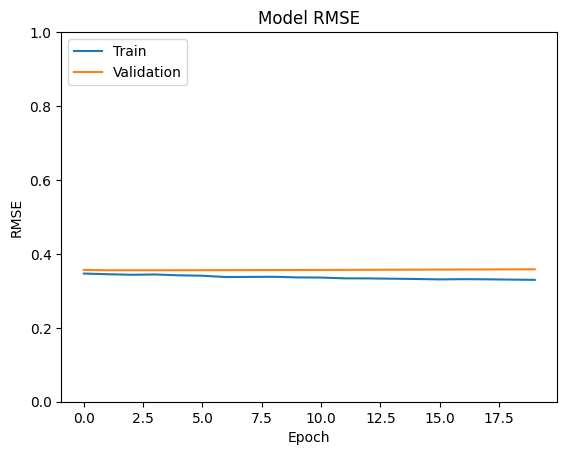

In [59]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Model RMSE')
plt.ylabel('RMSE')
plt.ylim(0,1)
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [60]:
def recommend_by_collaborative_filtering(user_id, model, data, place_encoded_to_place, top_n=10):
    """
    Mengembalikan rekomendasi Collaborative Filtering untuk seorang pengguna.

    Parameters:
    - user_id (int): ID pengguna yang akan direkomendasikan tempat.
    - model (tf.keras.Model): Model Collaborative Filtering yang telah dilatih.
    - data (pd.DataFrame): Data interaksi pengguna.
    - place_encoded_to_place (dict): Mapping dari encoded Place ke Place_Id.
    - top_n (int, optional): Jumlah rekomendasi yang diinginkan. Default is 10.

    Returns:
    - pd.DataFrame: Daftar rekomendasi dengan nama tempat, rating, dan kategori.
    """
    user_encoded = user_to_user_encoded.get(user_id)
    if user_encoded is None:
        print("User ID tidak ditemukan. Tidak dapat memberikan rekomendasi.")
        return pd.DataFrame()

    user_places = data[data['User_Id'] == user_id]['Place_Id'].tolist()
    user_places_encoded = [place_to_place_encoded.get(x) for x in user_places]

    all_places = set(place_ids)
    places_not_visited = list(all_places - set(user_places))
    places_not_visited_encoded = [place_to_place_encoded.get(x) for x in places_not_visited]

    user_array = np.array([user_encoded] * len(places_not_visited_encoded))
    place_array = np.array(places_not_visited_encoded)

    predictions = model.predict(np.vstack([user_array, place_array]).T).flatten()
    top_indices = predictions.argsort()[-top_n:][::-1]
    recommended_place_ids = [place_encoded_to_place.get(places_not_visited_encoded[i]) for i in top_indices]

    recommended_destinations = data_tourism_with_id_clean[
        data_tourism_with_id_clean['Place_Id'].isin(recommended_place_ids)
    ][['Place_Name', 'Category', 'Rating', 'Description']].copy()

    # Menambahkan nomor urut
    recommended_destinations.reset_index(drop=True, inplace=True)
    recommended_destinations.index += 1
    recommended_destinations.index.name = 'No.'

    return recommended_destinations

In [61]:
# Contoh rekomendasi
user_sample = data_collab['User_Id'].sample(1).iloc[0]
collab_recommendations = recommend_by_collaborative_filtering(user_sample, model, data_collab, place_encoded_to_place, top_n=10)
print(f"Rekomendasi berdasarkan Collaborative Filtering untuk User ID {user_sample}:")
display(collab_recommendations)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rekomendasi berdasarkan Collaborative Filtering untuk User ID 27:


,Place_Name,Category,Rating,Description
No.,,,,
1,Pantai Baron,Bahari,4.4,Pantai Baron adalah salah satu objek wisata be...
2,Pintoe Langit Dahromo,Cagar Alam,4.4,Pintu Langit Dahromo ini menyediakan berbagai ...
3,La Kana Chapel,Taman Hiburan,4.5,La Kana Chapel menawarkan konsep baru standing...
4,Goa Rong,Cagar Alam,4.3,Semarang memiliki wisata di ketinggian bernama...
5,Kampoeng Kopi Banaran,Taman Hiburan,4.3,"Kampoeng Kopi Banaran, sebuah agro wisata perk..."
6,Monumen Kapal Selam,Budaya,4.4,"Monumen Kapal Selam, atau disingkat Monkasel, ..."
7,Taman Keputran,Taman Hiburan,4.3,"Ntah, mengapa nama taman ini disebut dengan ta..."
8,Taman Ekspresi Dan Perpustakaan,Taman Hiburan,4.5,Taman Ekspresi Surabaya tidak hanya menyuguhka...
9,Keraton Surabaya,Budaya,4.4,Kawasan yang berjuluk Kampung Keraton ini terd...


# Evaluation

## Metrik Evaluasi
- **Precision@10:** Mengukur proporsi rekomendasi yang relevan di antara 10 rekomendasi teratas.
- **Root Mean Squared Error (RMSE):** Mengukur perbedaan antara nilai prediksi dan nilai aktual. Semakin rendah nilai RMSE, semakin baik performa model.
- **Mean Absolute Error (MAE):** Mengukur rata-rata kesalahan absolut antara nilai prediksi dan nilai aktual.

## Penjelasan Metrik

### MAE Formula:
$$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$
Di mana:
- $y_i$ adalah nilai aktual,
- $\hat{y}_i$ adalah nilai prediksi,
- $n$ adalah jumlah sampel.

**Mean Absolute Error (MAE)** mengukur rata-rata kesalahan absolut antara prediksi dan nilai aktual. Tidak seperti RMSE, yang mengkuadratkan setiap kesalahan, MAE menghitung nilai absolut dari perbedaan antara prediksi dan aktual, sehingga tidak terlalu sensitif terhadap kesalahan besar.

### RMSE Formula:
  $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$
  Di mana $y_i$ adalah nilai aktual dan $\hat{y}_i$ adalah nilai prediksi.

**RMSE** digunakan karena memberikan gambaran seberapa jauh prediksi model dari nilai aktual secara kuadrat, sehingga lebih sensitif terhadap kesalahan besar.

In [62]:
def evaluate_precision(recommendation_data, similarity_tags, similarity_desc, places_to_evaluate, top_n=10, desc_threshold=0.5):
    """
    Mengevaluasi Precision@10 berdasarkan Category dan Description.

    Parameters:
    - recommendation_data (pd.DataFrame): Dataset destinasi wisata yang telah diproses.
    - similarity_tags (sparse matrix): Matriks similarity berdasarkan Tags (Description + Category).
    - similarity_desc (sparse matrix): Matriks similarity berdasarkan Description.
    - places_to_evaluate (list): Daftar nama tempat yang akan dievaluasi.
    - top_n (int, optional): Jumlah rekomendasi yang diinginkan. Default is 10.
    - desc_threshold (float, optional): Threshold untuk similarity Description. Default is 0.5.

    Returns:
    - pd.DataFrame: Hasil evaluasi Precision@10 untuk setiap tempat.
    """
    evaluation_results = []
    precision_list = []

    for place in places_to_evaluate:
        print(f"\nEvaluasi untuk '{place}':")

        # Mendapatkan Place_Id yang direkomendasikan
        recommended_place_ids = get_content_based_recommendations(place, recommendation_data, similarity_tags, top_n=top_n)

        if not recommended_place_ids:
            print(f"Rekomendasi untuk '{place}' kosong.")
            continue

        # Mengambil informasi detail destinasi berdasarkan Place_Id
        recommended_destinations = recommendation_data[
            recommendation_data['Place_Id'].isin(recommended_place_ids)
        ][['Place_Name', 'Category', 'Rating', 'Description_Preprocessed']].copy()

        # Menambahkan kolom nomor urut
        recommended_destinations.reset_index(drop=True, inplace=True)
        recommended_destinations.index += 1
        recommended_destinations.index.name = 'No.'

        # Mendapatkan Category dan Description_Preprocessed dari tempat input
        input_place = recommendation_data[recommendation_data['Place_Name'] == place].iloc[0]
        input_category = input_place['Category']
        input_desc_preprocessed = input_place['Description_Preprocessed']

        # Menghitung similarity Description antara input place dan semua rekomendasi
        input_idx = recommendation_data[recommendation_data['Place_Name'] == place].index[0]
        desc_similarities = similarity_desc[input_idx, recommended_destinations.index - 1].toarray().flatten()

        # Menentukan relevansi berdasarkan Category atau Description similarity
        recommended_destinations['Description_Similarity'] = desc_similarities
        recommended_destinations['Relevance'] = ((recommended_destinations['Category'] == input_category) |
                                                  (recommended_destinations['Description_Similarity'] >= desc_threshold)).astype(int)

        # Menampilkan hasil rekomendasi beserta kesamaan deskripsi
        print(f"Rekomendasi:")
        display(recommended_destinations[['Place_Name', 'Category', 'Rating', 'Description_Similarity', 'Relevance']])

        # Menghitung True Positives (TP) dan False Positives (FP)
        TP = recommended_destinations['Relevance'].sum()
        FP = top_n - TP

        # Menghitung Precision@10
        precision = TP / top_n
        print(f"True Positive (TP): {TP}")
        print(f"False Positive (FP): {FP}")
        print(f"Precision@10 untuk '{place}': {precision * 100:.2f}%")
        print(f"Nilai kesamaan deskripsi untuk setiap rekomendasi:")

        # Menyimpan hasil evaluasi
        evaluation_results.append({
            'Place': place,
            'Precision@10': f"{precision * 100:.2f}%"
        })

        # Menyimpan nilai precision untuk rata-rata
        precision_list.append(precision)

    # Menghitung rata-rata Precision@10
    avg_precision = np.mean(precision_list) if precision_list else 0

    return pd.DataFrame(evaluation_results), avg_precision

In [63]:
# Mendefinisikan daftar tempat untuk evaluasi
places_to_evaluate = ['Museum Fatahillah']

# Mengevaluasi Precision@10 menggunakan fungsi evaluate_precision
evaluation_df, avg_precision = evaluate_precision(
    recommendation_data,
    similarity_tags,      # Matriks similarity berdasarkan Tags (Description + Category)
    similarity_desc,      # Matriks similarity berdasarkan Description
    places_to_evaluate,
    top_n=10,
    desc_threshold=0.5    # Threshold untuk similarity Description
)

# Menampilkan hasil evaluasi Precision@10
print("\n=== Hasil Evaluasi Precision@10 ===")
display(evaluation_df)


Evaluasi untuk 'Museum Fatahillah':
Rekomendasi:


,Place_Name,Category,Rating,Description_Similarity,Relevance
No.,,,,,
1,Kota Tua,Budaya,4.6,0.052221,1
2,Museum Nasional,Budaya,4.6,0.171963,1
3,Museum Seni Rupa dan Kramik,Budaya,4.4,0.047923,1
4,Museum Joang 45,Budaya,4.0,0.051913,1
5,Museum Kebangkitan Nasional,Budaya,4.7,0.019368,1
6,Museum Tengah Kebun,Budaya,4.6,0.038899,1
7,Museum Sonobudoyo Unit I,Budaya,4.6,0.027344,1
8,Museum Sri Baduga,Budaya,4.5,0.011554,1
9,Museum Gedung Sate,Budaya,4.6,0.037989,1


True Positive (TP): 10
False Positive (FP): 0
Precision@10 untuk 'Museum Fatahillah': 100.00%
Nilai kesamaan deskripsi untuk setiap rekomendasi:

=== Hasil Evaluasi Precision@10 ===


,Place,Precision@10
0,Museum Fatahillah,100.00%


In [64]:
# Mendapatkan prediksi untuk data validasi
y_pred_cf = model.predict(x_val_cf).flatten()

# Menghitung RMSE dan MAE
rmse_cf = np.sqrt(mean_squared_error(y_val_cf, y_pred_cf))
mae_cf = mean_absolute_error(y_val_cf, y_pred_cf)

print(f"Collaborative Filtering - RMSE: {rmse_cf:.4f}")
print(f"Collaborative Filtering - MAE: {mae_cf:.4f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Collaborative Filtering - RMSE: 0.3583
Collaborative Filtering - MAE: 0.3105


In [65]:
# Menampilkan hasil evaluasi
print("=== Evaluation Results ===")
print(f"Content-based Filtering - Precision@10: {avg_precision * 100:.2f}%")
print(f"Collaborative Filtering - RMSE: {rmse_cf:.4f}")
print(f"Collaborative Filtering - MAE: {mae_cf:.4f}")

=== Evaluation Results ===
Content-based Filtering - Precision@10: 100.00%
Collaborative Filtering - RMSE: 0.3583
Collaborative Filtering - MAE: 0.3105


In [66]:
# Membuat DataFrame untuk hasil evaluasi
evaluation_results_final = pd.DataFrame({
    'Metric': ['Precision@10', 'RMSE', 'MAE'],
    'Content-based Filtering': [f"{avg_precision * 100:.2f}%", np.nan, np.nan],
    'Collaborative Filtering': [np.nan, f"{rmse_cf:.4f}", f"{mae_cf:.4f}"]
})

# Menampilkan DataFrame Evaluasi Akhir
display(evaluation_results_final)

,Metric,Content-based Filtering,Collaborative Filtering
0,Precision@10,100.00%,NaN
1,RMSE,NaN,0.3583
2,MAE,NaN,0.3105


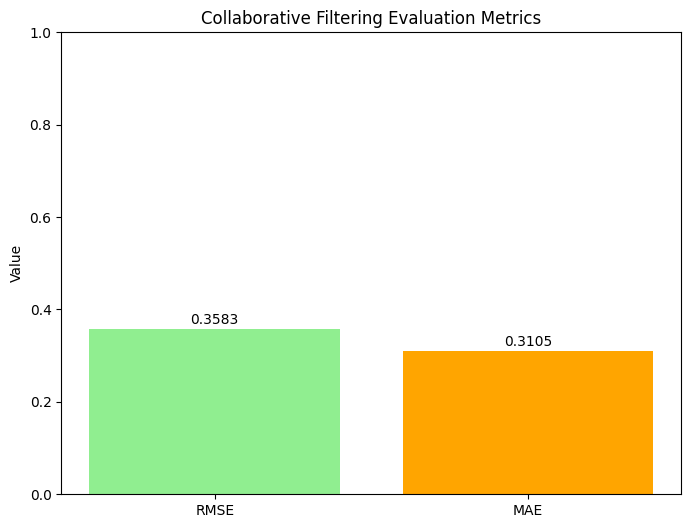

In [67]:
# Plot RMSE dan MAE untuk Collaborative Filtering
plt.figure(figsize=(8,6))
plt.bar(['RMSE', 'MAE'], [rmse_cf, mae_cf], color=['lightgreen', 'orange'])
plt.title('Collaborative Filtering Evaluation Metrics')
plt.ylabel('Value')
plt.ylim(0, 1)
for i, v in enumerate([rmse_cf, mae_cf]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.show()